# Reconocimiento de Imágenes en CIFAR10

Para experimentar con el reconocimiento de imágenes y la clasificación se estudia el dataset *CIFAR10*, el cual contiene 60.000 imagenes de 32 $\times$ 32 (pixeles), donde cada imagen pertenece a una de las diez clases, clasificación excluyente (gato, perro, rana, caballo, pájaro, ciervo, avión, automóvil, camión y barco). Los datos vienen estructurado en un formato RGB, donde cada imagen (fila del dataset) corresponde a 3072 características, dividido en los 3 canales de RGB (1024 cada uno) correspondiente a cada imagen.  
Los datos vienen separados en datos de entrenamiento y de pruebas, para un estudio eficiente con las distintas arquitecturas que ofrecen las *redes neuronales*, además de analizar distintas representaciones de imágenes.

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13757123246873530957, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 5177344
 locality {
   bus_id: 1
 }
 incarnation: 11844238406619785074
 physical_device_desc: "device: 0, name: GeForce 940M, pci bus id: 0000:01:00.0"]

**Update:** Ejecutado con tensorflow para comparar con theano.

In [6]:
import os    
#os.environ['THEANO_FLAGS'] = "device=gpu,floatX=float32,cuda.root=/usr/local/cuda-7.5/" 

#import theano
import keras
#print(theano.config)

import matplotlib.pyplot as plt
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler

from scipy.misc import imread
import cPickle as pickle
import numpy as np
import math

Para el desarrollo de esta actividad se utilizará una GPU, utilizando un driver nvidia GeForce 940M, acelerando en una gran cantidad los cálculos realizados por la red convolucional.

[[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 ..., 
 [ 71  60  74 ...,  68  69  68]
 [250 254 211 ..., 215 255 254]
 [ 62  61  60 ..., 130 130 131]]
('min value', 0)
('max value', 255)


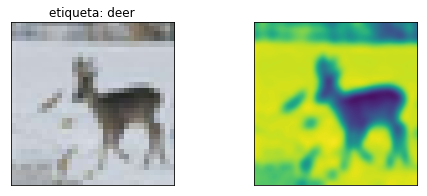

In [4]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

dict1 = unpickle("data/data_batch_1")
X = dict1["data"]
print(X)
Y = dict1['labels']
print("min value" ,min(X[0]))
print("max value" ,max(X[0]))

label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

def ver_imagen(X,Y,n):
    aux = X[n].reshape(3,1024).copy()
    canal_r = aux[0].reshape(32,32)
    canal_g = aux[1].reshape(32,32)
    canal_b = aux[2].reshape(32,32)
    
    f,ax = plt.subplots(1,2,figsize=(8,3))
    ax[0].set_title("etiqueta: "+label_names[Y[n]])
    
    imagen = X[n].reshape(3,32,32)
    imagen = imagen.transpose([1, 2, 0])

    ax[0].imshow(imagen)
    ax[0].set_yticks([])
    ax[0].set_xticks([])

    ax[1].imshow(canal_r, interpolation="bicubic")
    ax[1].imshow(canal_g, interpolation="bicubic")
    ax[1].imshow(canal_b, interpolation="bicubic")
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    plt.show()
    
ver_imagen(X,Y,20)

### Cargar Dataset

In [12]:
def load_CIFAR_one(filename):
    with open(filename, "rb") as f:
        datadict = pickle.load(f)
        X = datadict["data"]
        Y = datadict["labels"]
        return X, np.array(Y)

def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, "data_batch_%d" % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, "test_batch"))
    
    #adding Xval
    index = np.arange(np.shape(Xtr)[0]) #filas 
    np.random.shuffle(index) #permutan las filas
    X = Xtr[index, :] #matriz permutada
    Y = Ytr[index]
    #l =  np.random.randint(1000,5000) #entrego 4259
    l = 4259
    Xval,Xtr = np.split(X,[l])
    Yval,Ytr = np.split(Y,[l])
    
    return Xtr, Ytr, Xte, Yte,Xval,Yval

x_train,y_train, x_test,y_test, x_val,y_val = load_CIFAR10('data/')

#ESCALAR

x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0


print('Training set shape: ',x_train.shape)
print('Validation set shape: ',x_val.shape)
print('Test set shape: ',x_test.shape )

('Training set shape: ', (45741, 3072))
('Validation set shape: ', (4259, 3072))
('Test set shape: ', (10000, 3072))


En la celda anterior se carga el dataset de CIFAR10, el cual está dividido en 5 *batchs*, y se crean las matrices $X_{train}$, $Y_{train}$, $X_{test}$, $Y_{test}$ y $X_{val}$, $Y_{val}$. El conjunto de validación es creado a partir del *training set* y este no supera los 5000 datos. Las filas de estas matrices representan a cada imagen del dataset, siendo los valores de cada columna enteros entre 0 y 255, que representan la intensidad de los píxeles en la magen, es decir, de los colores que vienen por los canales *R*,*G* y *B*.  
Se puede observar que la matriz $X_{train}$ posee 45741 filas, es decir, 45741 imagenes de entrenamiento. Por otro lado $X_{val}$ posee 4259 imágenes de validación y $X_{test}$ 10000 imágenes de prueba. Las 10 etiquetas presentes en este problema están codificadas en números enteros del 0 al 9. Siendo las siguientes:  
* airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

En esta celda además se escala la representación matricial de píxeles de las imágenes, para poder trabajarlas de forma apropiada, normalizando por la intensidad máxima 255, dejando cada atributo en un intervalo continuo entre 0 y 1.

In [8]:
def plot_function(hist):
    loss_values1 = hist['loss']
    val_loss_values1 = hist['val_loss']
    epochs1 = range(1, len(loss_values1) + 1)
    f, axarr = plt.subplots(1, 2,figsize=(16,5))
    
    axarr[0].plot(epochs1, loss_values1, 'bo-')
    axarr[0].plot(epochs1, val_loss_values1, 'go-')
    axarr[0].set_title('Loss de CNN')
    axarr[0].set_ylim(0,2)
    axarr[0].set_xlabel('Epochs')
    axarr[0].set_ylabel('Loss')

    acc = hist['acc']
    val_acc = hist['val_acc']
    axarr[1].plot(epochs1,  np.subtract(1,acc), 'bo-', label = "Training set")
    axarr[1].plot(epochs1, np.subtract(1,val_acc), 'go-', label = "Test set")
    axarr[1].set_title('Error de CNN')
    axarr[1].set_ylim(0,.8)
    axarr[1].set_xlabel('Epochs')
    axarr[1].set_ylabel('Error')
    axarr[1].legend(loc="upper right", fancybox= True)
    plt.show()  

## A) Ajuste/Preprocesamiento

In [13]:
x_train = x_train.reshape((x_train.shape[0],32,32,3))
#x_train = x_train.transpose([0, 1, 2, 3]) #only if 'tf' dim-ordering is to be used
x_test= x_test.reshape((x_test.shape[0],32,32,3))
#x_test= x_test.transpose([0, 2, 3,1] )#remove if 'th' dim-ordering is to be used

y_train = keras.utils.np_utils.to_categorical(y_train, 10)
y_test = keras.utils.np_utils.to_categorical(y_test, 10)
print x_train.shape

(45741, 32, 32, 3)


En la celda anterior, se preprocesan la representación de las imagenes de entrada, donde cada imagen es transformada a una matriz cuadrada de 32x32, una para cada canal RGB. Esto se realiza para el posterior uso en las capas convolucionales. A su vez, como este problema es de clasificación excluyente, las etiquetas se representan como *one-hot vectors*, donde cada componente del vector está asociada a la clase de la imagen. En la posición donde se encuentre un 1 implicará que esa clase es la que corresponde a la imagen, el resto tomará el valor 0.

## B) Definir una CNN ( C x P )

In [15]:
model = Sequential()
model.add(Conv2D( 64, (3, 3) , padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D( 64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_10 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
__________

En este item, se define una arquitectura típica de CNN (Convolutional Neyral Network), la cual consiste en capas de convolución alternadas por capas de pooling para terminar con las capas totalmente conectadas, capas características de las redes Feed Forward. 

Inicialmente, el input pasa por una capa convolucional con 64 filtros de 3x3, cuya funcionalidad principal es la extracción de características relevantes de la imagen. Luego de pasar por esta, se le aplica la función de activación para cada uno, en este caso la función **Relu**. A continuación viene una fuerte reducción de dimensionalidad por causa de la capa de Max pooling, la cual, en un espacio de 2x2 filtra y deja el punto máximo, esperando que allí se encuentre con mayor probabilidad una característica importante. Esta secuencia convolución/pooling se repite para la 3° y 4° capa respectivamente.

Cabe destacar que el campo receptivo de las neuronas en las capas convolucionales está dado por el tamaño de los filtros/kernels, estos a su vez dependen de los pesos los cuales se repiten a la hora de analizar la imagen de entrada (*parameter sharing*). Esto reduce altamente la cantidad de parámetros que la red tiene que aprender en comparación con una red con capas altamente conectadas como las que posee la red Feed Forward.

En las capas anteriores, hemos preservado la topología de la imagen con los filtros. Ahora que ya se han procesado las características relevantes, se introduce una capa densa altamente conectada que sirve para realizar permutaciones/combinatorias sobre las características obtenidas y con esto predecir a la clase que la imagen podría pertenecer.

Finalmente, se presenta una capa con 10 neuronas, una por cada clase, con función de activación Soft-Max (para que la sumatoria de las probabilidades de las neuronas sume 1) que como resultado entrega las probabilidades de que la imagen pertenezca a cada clase.

En la celda anterior se aprecia la cantidad de parámetros totales de la red, en la primera capa convolucional hay 1792, que equivale al producto de 64 \* 3 \* 3 \* 3  + 64, esto es 64 filtros de 3x3 en 3 canales y a eso se le añade el sesgo (*bias*) de cada filtro. En la segunda capa convolucional hay 36928 parámetros que aprender. En las capas FF hay 2097664 pesos que aprender, dado la cantidad de parámetros entre las neuronas en las capas contiguas y su respectivo sesgo, 4096 \* 512 + 512 = 2097664. Así hay un total de 2 millones parámetros aproximademente que la red debe aprender entre todas las capas, esto es mucho menor que una red FF, ya que si a diferencia de ocupar redes convolucionales hubieramos utilizado 3 capas FF, la cantidad de parámetros se hubiera disparado a (4096)^3 = 68 mil millones aproximadamente.

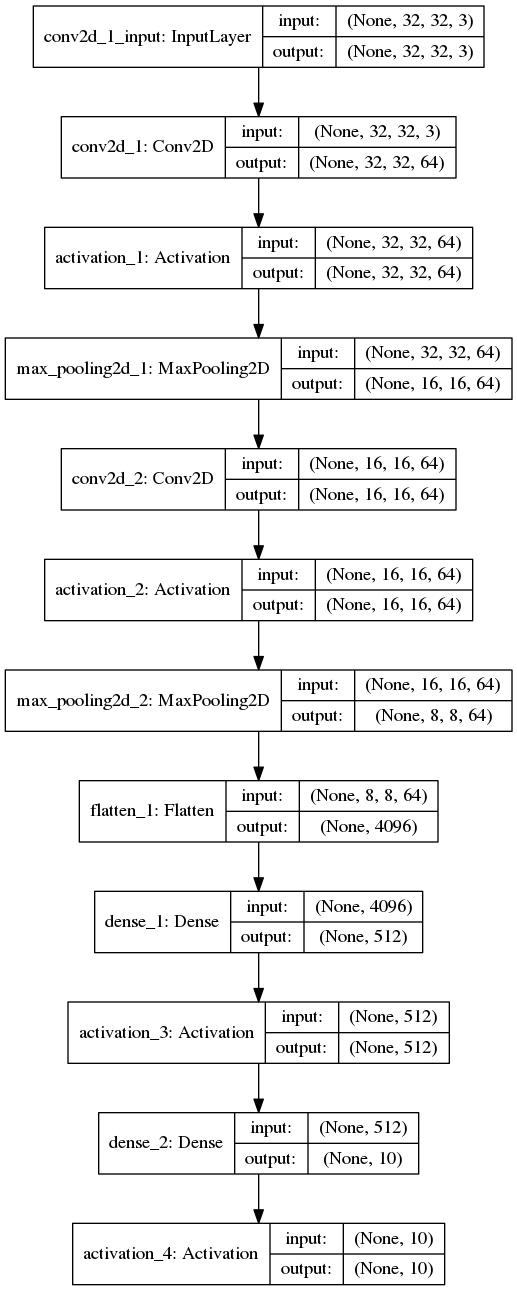

In [6]:
plot_model(model, to_file='aux.png', show_shapes=True)
Image(filename='aux.png') 

En esta celda se aprecia las reducciones de dimensionalidad que va sufriendo la entrada a medida que realiza un *forward pass* en la red convolucional. En un comienzo, entra la imagen entera que posee 3072 pixeles distribuidos en 3 canales, cada uno con dimensiones de 32x32, pasando por 64 kernels de 3x3 y por la respectiva función de activación de la capa. Con la capa de pooling de 2x2, la imagen disminuye en un cuarto de su tamaño original, ahora la imagen es de 16x16, se le aplica nuevamente una capa de convolución y pooling hasta quedar de dimensiones 8x8.

Se realiza una transformacion de *flatten* (representar todo en un arreglo unidimensional) a los 64 canales de 8x8, dejando así 4096 neuronas en la capa FF, luego otra capa densa de 512  y finalmente la salida de la red con la cantidad de clases que una imagen puede tener.

## C) Entrenar la red (SGD)

In [16]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile( optimizer=opt, loss='categorical_crossentropy',metrics=['acc'])
hist2 = model.fit(x_train, y_train,batch_size=100,epochs=25,
validation_data=(x_test, y_test),shuffle=True,callbacks=[lrate],verbose=1)

Train on 45741 samples, validate on 10000 samples
Epoch 1/25
45741/45741 [==============================] - 58s - loss: 2.1050 - acc: 0.2479 - val_loss: 1.9301 - val_acc: 0.2978
Epoch 2/25
45741/45741 [==============================] - 48s - loss: 1.8287 - acc: 0.3539 - val_loss: 1.7397 - val_acc: 0.3783
Epoch 3/25
45741/45741 [==============================] - 47s - loss: 1.6821 - acc: 0.4034 - val_loss: 1.5928 - val_acc: 0.4363
Epoch 4/25
45741/45741 [==============================] - 47s - loss: 1.5854 - acc: 0.4402 - val_loss: 1.5843 - val_acc: 0.4411
Epoch 5/25
45741/45741 [==============================] - 46s - loss: 1.5177 - acc: 0.4685 - val_loss: 1.4973 - val_acc: 0.4746
Epoch 6/25
45741/45741 [==============================] - 45s - loss: 1.4879 - acc: 0.4754 - val_loss: 1.4792 - val_acc: 0.4742
Epoch 7/25
45741/45741 [==============================] - 45s - loss: 1.4594 - acc: 0.4870 - val_loss: 1.4530 - val_acc: 0.4879
Epoch 8/25
45741/45741 [==============================

En la celda anterior se entrena el modelo convolucional definido anteriormente a través del clásico optimizador SGD con una tasa de aprendizaje adaptativa que va disminuyendo en el entrenamiento, la cual se divide por 2 cada 10 epochs. En este entrenamiento se puede ver la reducción del tiempo de ejecución por epochs, demorando 60 segundos con GPU, ya que a través de la CPU el entrenamiento por epochs era aproximadamente 4 mil segundos.  
Por la naturaleza del problema, se utiliza la función de pérdida **categorical crossentropy** (extensión de binary *cross entropy* con n> 2 clases).

**Udate**: disminuyó de 60 segundos a 45 por cada epoch utilizando la ultima version de CUDA + tensorflow + CudNN

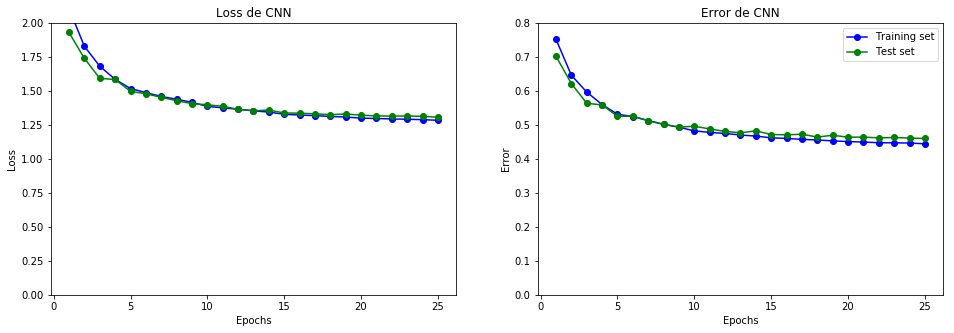

In [17]:
history_dict = hist2.history
plot_function(history_dict)

En esta celda se aprecia el error y *loss* de entrenamiento y prueba en función de los epochs. En ambos gráficos se observa una tendencia similar, los errores ya sea de entrenamiento y de prueba poseen una magnitud casi idéntica, lo que era inusual en las redes FF, donde en la mayoría de los casos el error de pruebas era mayor en creces al de entrenamiento por causa del *overfitting*. Este es el comportamiento que se puede analizar con esta cantidad de epochs, ya que puede suceder que con una cantidad mayor de epochs se produzca este fenómeno.  
La idea de controlar la tasa de aprendizaje tuvo éxito, observando en las primeras 10 epochs que el error disminuye en una cantidad considerable, estancando el valor del error a medida que se va dividiendo por dos esta tasa.  
Podríamos haber dejado fija esta tasa pero está el riesgo de divergencia de la red (pesos divergen en búsqueda de un óptima y oscilan sin éxito).

In [18]:
score = model.evaluate(x_test, y_test)
print "\nTEST CROSS ENTROPY LOSS = ", score[0]
print "\nTEST ACCURACY = ", score[1]

10000/10000 [==============================] - 4s     

TEST CROSS ENTROPY LOSS =  1.30692815437

TEST ACCURACY =  0.5399


En la celda anterior se muestra el rendimiento de la red con los datos de prueba, siendo la pérdida de *Cross Entropy* un valor de 1.32 y la precisión (*accurac*) de las predicciones fue de **54,1%**. Esto implica que un poco más de la mitad de las predicciones realizadas por la red tuvo éxito.

## D) Entrenar la red (RMSProp)

In [19]:
opt = rmsprop(lr=0.001, decay=1e-3)
model.compile( optimizer=opt, loss='categorical_crossentropy' ,metrics=['acc'])
hist3 = model.fit(x_train, y_train,batch_size=100,epochs=25,
validation_data=(x_test, y_test),shuffle=True)

Train on 45741 samples, validate on 10000 samples
Epoch 1/25
45741/45741 [==============================] - 52s - loss: 1.8496 - acc: 0.4518 - val_loss: 1.2833 - val_acc: 0.5488
Epoch 2/25
45741/45741 [==============================] - 52s - loss: 1.1842 - acc: 0.5834 - val_loss: 1.2114 - val_acc: 0.5749
Epoch 3/25
45741/45741 [==============================] - 50s - loss: 1.0150 - acc: 0.6436 - val_loss: 1.1033 - val_acc: 0.6139
Epoch 4/25
45741/45741 [==============================] - 50s - loss: 0.8906 - acc: 0.6901 - val_loss: 1.0936 - val_acc: 0.6192
Epoch 5/25
45741/45741 [==============================] - 50s - loss: 0.7872 - acc: 0.7292 - val_loss: 1.1035 - val_acc: 0.6268
Epoch 6/25
45741/45741 [==============================] - 50s - loss: 0.7036 - acc: 0.7585 - val_loss: 1.0175 - val_acc: 0.6554
Epoch 7/25
45741/45741 [==============================] - 50s - loss: 0.6240 - acc: 0.7884 - val_loss: 1.0234 - val_acc: 0.6552
Epoch 8/25
45741/45741 [==============================

En esta celda se entrena el mismo modelo entrenado anteriormente, esta vez con el método optimizador **RMSProp** y con una tasa de aprendizaje inicialmente baja de 0.001 con un decay de 1e-3.

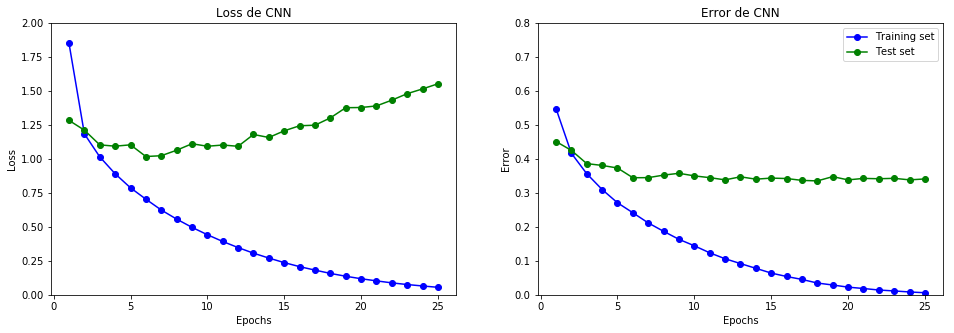

In [20]:
history_dict = hist3.history
plot_function(history_dict)

A partir de los gráficos de error y *loss* en el set de entrenamiento y prueba, se puede apreciar que hay sustanciales mejoras en los resultados con este optimizador. Ambos valores convergen a un valor menor que los obtenidos en el caso anterior con SGD, aunque se presenta de manera notoria el fenómeno de *overfitting* en ambos casos, es decir, el modelo se sobre ajusta a los datos de entrenamiento no generalizando la información extraida. Las diferencias de error en el conjunto de prueba entre SGD y RMSprop es considerable, pero más aún es la diferencia en el entrenamiento, ya que pasado 25 epochs RMSprop tiene un error alrededor del 0.05 y SGD cercano a 0.45, aproximadamente 9 veces el error de RMSProp. Podemos concluir empíricamente para este caso, que RMSprop es un optimizador mas sofisticado que obtiene mejor resultado para entrenar redes neuronales convolucionales.

In [9]:
score = model.evaluate(x_test, y_test)
print "\nTEST CROSS ENTROPY LOSS = ", score[0]
print "\nTEST ACCURACY = ", score[1]

 9824/10000 [============================>.] - ETA: 0s
TEST CROSS ENTROPY LOSS =  1.14163003025

TEST ACCURACY =  0.6824


Despúes de 25 epochs, la función de pérdida *Cross Entropy* resulta en 1.14 y la precisión (*accuracy*) del modelo es de **68,24%** siendo un valor bastante bueno para este dataset y mejorando un 14% respecto al optimizador SGD.

## E) Variar red ( C x C x P )

In [5]:
model = Sequential()
#primera C C P
model.add(Conv2D( 64, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D( 64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#segunda C C P
model.add(Conv2D( 128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D( 128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
__________

En la celda anterior, nuevamente se genera una nueva arquitectura de red convolucional, esta vez a diferencia de las generadas anteriormente se utilizan 2 capas convolucionales en vez de 1 y luego una capa de pooling. En la primera tanda de capas convolucionales se utilizan 64 filtros de 2x2 y en la segunda tanda 128 filtros del mismo tamaño anterior. Se añade un regularizador Dropout de 25% luego de cada tanda de capas convolucionales y un Dropout de 30% en la capa *Feed Forward* para que no se produzca un *overfitting* tan intenso, ya que en este caso se tiene una red mas profunda que la anterior (2 capas extras convolucionales), por lo que es sensible a *overfitting*

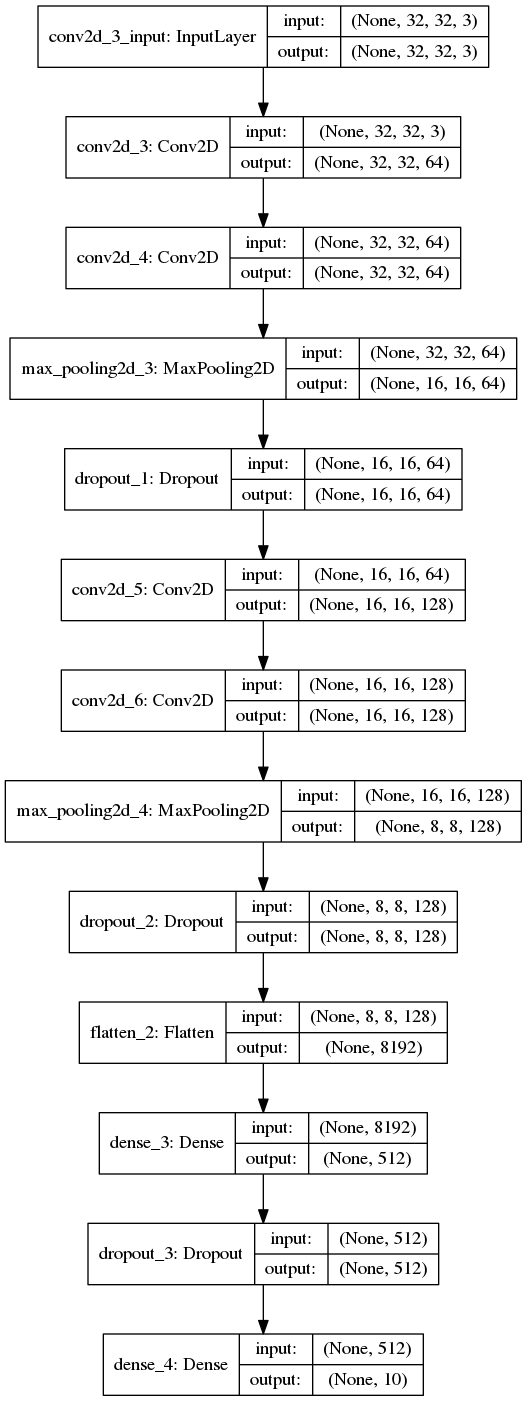

In [11]:
plot_model(model, to_file='aux.png', show_shapes=True)
Image(filename='aux.png')

La imagen anterior muestra cómo es transformado el input de entrada para finalmente entregar un resultado que predice a cuál clase corresponde la imagen.

In [6]:
opt = rmsprop(lr=0.001, decay=1e-3)
model.compile( optimizer=opt, loss='categorical_crossentropy' ,metrics=['acc'])
hist4 = model.fit(x_train, y_train,batch_size=100,epochs=25,
                  validation_data=(x_test, y_test),shuffle=True,verbose=1)

Train on 45741 samples, validate on 10000 samples
Epoch 1/25
45741/45741 [==============================] - 166s - loss: 1.7271 - acc: 0.3794 - val_loss: 1.5520 - val_acc: 0.4434
Epoch 2/25
45741/45741 [==============================] - 169s - loss: 1.2818 - acc: 0.5479 - val_loss: 1.2238 - val_acc: 0.5628
Epoch 3/25
45741/45741 [==============================] - 172s - loss: 1.0954 - acc: 0.6151 - val_loss: 1.0452 - val_acc: 0.6339
Epoch 4/25
45741/45741 [==============================] - 172s - loss: 0.9707 - acc: 0.6580 - val_loss: 1.0270 - val_acc: 0.6423
Epoch 5/25
45741/45741 [==============================] - 161s - loss: 0.8835 - acc: 0.6913 - val_loss: 0.9306 - val_acc: 0.6763
Epoch 6/25
45741/45741 [==============================] - 161s - loss: 0.8062 - acc: 0.7177 - val_loss: 0.9148 - val_acc: 0.6835
Epoch 7/25
45741/45741 [==============================] - 161s - loss: 0.7526 - acc: 0.7374 - val_loss: 0.9077 - val_acc: 0.6905
Epoch 8/25
45741/45741 [=======================

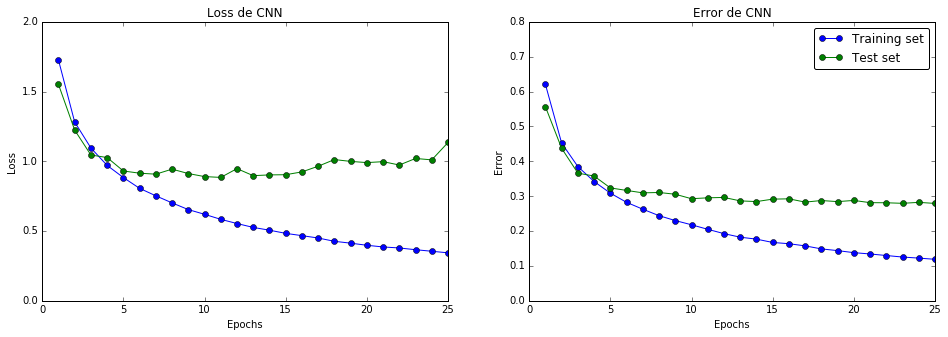

In [7]:
history_dict = hist4.history
plot_function(history_dict)

Con el modelo anteriormente definido y entrenado de la misma forma que el modelo con doble capas convolucionales, RMSprop, se obtiene un gráfico muy similar al analizado anteriormente, pero la incorporación de las nuevas capas convolucionales mejoraron las métricas de la red.

In [8]:
score = model.evaluate(x_test, y_test)
print "\nTEST CROSS ENTROPY LOSS = ", score[0]
print "\nTEST ACCURACY = ", score[1]

 9984/10000 [============================>.] - ETA: 0s
TEST CROSS ENTROPY LOSS =  1.1348450264

TEST ACCURACY =  0.7208


Con esta nueva arquitectura de red se obtuvo un aumento de 4% de precisión en comparación con una capa convolucional simple, quedando así una precisión de **72,08%**, superando el 70% que se solicita en el enunciado de la tarea, es decir estos resultados muestran que situar una capa convolucional luego de una de pooling genera una reducción prematura del patron de entrada, por lo que con dos capas convolucionales contiguas se tiene un poder de procesamiento mayor en donde se logran extraer características más útiles para la clasificación de las imágenes en CIFAR10, ya que este resultado indica que un 70% de las imágenes son correctamente etiquetadas.

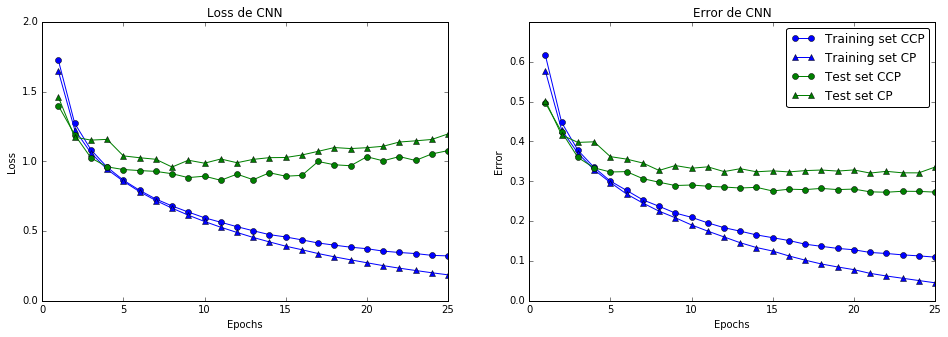

In [20]:
history_dict1 = hist4.history #modelos a comparar

history_dict2 = hist3.history #modelo a comparar

f, axarr = plt.subplots(1, 2,figsize=(16,5))

loss_values1 = history_dict1['loss']
val_loss_values1 = history_dict1['val_loss']
loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']
epochs1 = range(1, len(loss_values1) + 1)

axarr[0].plot(epochs1, loss_values1, 'bo-', label = "Training set CCP")
axarr[0].plot(epochs1, loss_values2, 'b^-', label = "Training set CP")
axarr[0].plot(epochs1, val_loss_values1, 'go-', label = "Test set CCP")
axarr[0].plot(epochs1, val_loss_values2, 'g^-', label = "Test set CP")
axarr[0].set_title('Loss de CNN')
axarr[0].set_ylim(0,2)
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

acc1 = history_dict1['acc']
val_acc1 = history_dict1['val_acc']
acc2 = history_dict2['acc']
val_acc2 = history_dict2['val_acc']

axarr[1].plot(epochs1, np.subtract(1,acc1), 'bo-', label = "Training set CCP")
axarr[1].plot(epochs1, np.subtract(1,acc2), 'b^-', label = "Training set CP")
axarr[1].plot(epochs1, np.subtract(1,val_acc1), 'go-', label = "Test set CCP")
axarr[1].plot(epochs1, np.subtract(1,val_acc2), 'g^-', label = "Test set CP")
axarr[1].set_title('Error de CNN')
axarr[1].set_ylim(0,0.7)
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Error')
axarr[1].legend(loc="upper right", fancybox= True)

plt.show()

En este gráfico se comparan los entrenamientos de los dos modelos propuestos anteriormente, una arquitectura Convolucional-Pooling (CP) y otra Convolucional-Convolucional-Pooling (CCP), pudiendo observar que el método CCP produce un menor *overfitting* gracias al regularizador de Dropout y que entrega un mejor comportamiento a lo largo del entrenamiento en el conjunto de pruebas, esto puede ser explicado ya que al utilizar dos capas convolucionales contiguas el modelo realiza una mejor extracción de características de la imagen que una sola, ya que podría darse el caso en que una capa convolucional detecte ojos y la otra en base a esta información detecte que existe un rostro.  
En conjunto con el valor de *accuracy* obtenido se puede concluir que el modelo de CCP estaba en lo correcto y supera al anterior gracias al aplazamiento de la capa de pooling a una capa después.

### Menos filtros en la capa siguiente ( Intercambio en cantidad de filtros)

In [21]:
model = Sequential()
model.add(Conv2D( 128, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D( 128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D( 64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D( 64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
__________

En la celda anterior se define un modelo CCP igualmente al anteriormente definido solo que alternando el número de filtros por capas, ya que esto no resultaba tan lógico por lo que se decidió experimentar este factor en primer lugar, entrenándo el modelo al igual que en los modelos anteriores en las celdas siguientes.

In [23]:
opt = rmsprop(lr=0.001, decay=1e-3)
model.compile( optimizer=opt, loss='categorical_crossentropy' ,metrics=['acc'])
hist5 = model.fit(x_train, y_train,batch_size=100,epochs=25,
validation_data=(x_test, y_test),shuffle=True,verbose=1)

Train on 45741 samples, validate on 10000 samples
Epoch 1/25
45741/45741 [==============================] - 282s - loss: 1.7423 - acc: 0.3755 - val_loss: 1.3898 - val_acc: 0.5004
Epoch 2/25
45741/45741 [==============================] - 285s - loss: 1.3039 - acc: 0.5386 - val_loss: 1.2387 - val_acc: 0.5561
Epoch 3/25
45741/45741 [==============================] - 283s - loss: 1.1280 - acc: 0.6014 - val_loss: 1.1390 - val_acc: 0.5909
Epoch 4/25
45741/45741 [==============================] - 283s - loss: 1.0158 - acc: 0.6440 - val_loss: 1.0425 - val_acc: 0.6343
Epoch 5/25
45741/45741 [==============================] - 283s - loss: 0.9367 - acc: 0.6730 - val_loss: 0.9578 - val_acc: 0.6610
Epoch 6/25
45741/45741 [==============================] - 283s - loss: 0.8666 - acc: 0.6969 - val_loss: 0.9578 - val_acc: 0.6625
Epoch 7/25
45741/45741 [==============================] - 283s - loss: 0.8111 - acc: 0.7169 - val_loss: 0.9126 - val_acc: 0.6745
Epoch 8/25
45741/45741 [=======================

In [24]:
score = model.evaluate(x_test, y_test)
print "\nTEST CROSS ENTROPY LOSS = ", score[0]
print "\nTEST ACCURACY = ", score[1]

10000/10000 [==============================] - 11s    

TEST CROSS ENTROPY LOSS =  0.91770440731

TEST ACCURACY =  0.7181


Se puede ver en primer lugar que el *accuracy* logrado de **71,81%** no supera el modelo anterior el cual aumenta el número de filtros en la segunda tanda de capa convolucional.

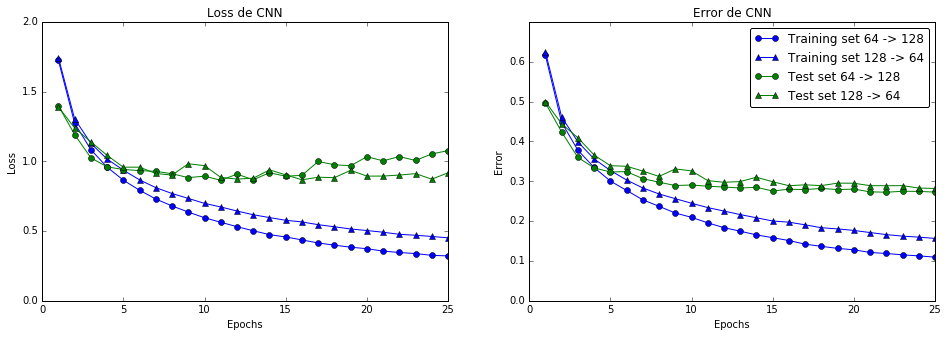

In [25]:
history_dict1 = hist4.history
history_dict2 = hist5.history

f, axarr = plt.subplots(1, 2,figsize=(16,5))

loss_values1 = history_dict1['loss']
val_loss_values1 = history_dict1['val_loss']
loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']
epochs1 = range(1, len(loss_values1) + 1)

axarr[0].plot(epochs1, loss_values1, 'bo-')
axarr[0].plot(epochs1, loss_values2, 'b^-')
axarr[0].plot(epochs1, val_loss_values1, 'go-')
axarr[0].plot(epochs1, val_loss_values2, 'g^-')
axarr[0].set_title('Loss de CNN')
axarr[0].set_ylim(0,2)
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

acc1 = history_dict1['acc']
val_acc1 = history_dict1['val_acc']
acc2 = history_dict2['acc']
val_acc2 = history_dict2['val_acc']

axarr[1].plot(epochs1, np.subtract(1,acc1), 'bo-', label = "Training set 64 -> 128")
axarr[1].plot(epochs1, np.subtract(1,acc2), 'b^-', label = "Training set 128 -> 64")
axarr[1].plot(epochs1, np.subtract(1,val_acc1), 'go-', label = "Test set 64 -> 128")
axarr[1].plot(epochs1, np.subtract(1,val_acc2), 'g^-', label = "Test set 128 -> 64")
axarr[1].set_title('Error de CNN')
axarr[1].set_ylim(0,0.7)
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Error')
axarr[1].legend(loc="upper right", fancybox= True)
plt.show()

En el gráfico anterior se comparan los dos modelos CCP-CCP entrenados, en uno aumentando el número de filtros y el otro disminuyendo el número de filtros en el segundo CCP.  
Se observa que en el error del modelo a lo largo del entrenamiento que se comporta mejor es el de aumentar el número de filtros en el segundo CCP, siendo mejor en conjunto de entrenamiento como en el de pruebas. Por otro lado en la función de pérdida se observa que a lo largo del entrenamiento el modelo que disminuye el número de filtros tiene una menor pérdida sobre el conjunto de pruebas.  
Finalmente se puede preferir al modelo que aumenta el número de filtros debido a que lo que se espera es tener un bajo error y alto *accuracy*, no necesariamente una baja pérdida, además de que el modelo tiene más lógica ya que luego del pooling se reduce la dimensionalidad por lo que quizas sea necesario aumentar el almacenamiento de información a través de aumentar el número de filtros y con esto los canales resultantes.

### > Cambio del tamaño del filtro

In [9]:
model = Sequential()
model.add(Conv2D( 64, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D( 64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D( 128, (5, 5), padding='same', activation='relu'))
model.add(Conv2D( 128, (5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       409728    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 128)         0         
__________

En la celda anterior se define un modelo CCP igualmente al anteriormente definido solo que se varía el tamaño del filtro, pasando de un filtro de menor tamaño a uno de mayor en cada tanda de capas convolucionales como se puede ver en la definición del modelo. El modelo es entrenado al igual que en los modelos anteriores, con RMSprop y función de pérdida *categorical cross-entropy*.

In [10]:
opt = rmsprop(lr=0.001, decay=1e-3)
model.compile( optimizer=opt, loss='categorical_crossentropy' ,metrics=['acc'])
hist6 = model.fit(x_train, y_train,batch_size=100,epochs=25,
                  validation_data=(x_test, y_test),shuffle=True,verbose=1)

Train on 45741 samples, validate on 10000 samples
Epoch 1/25
45741/45741 [==============================] - 225s - loss: 1.7727 - acc: 0.3622 - val_loss: 1.3998 - val_acc: 0.4915
Epoch 2/25
45741/45741 [==============================] - 226s - loss: 1.2850 - acc: 0.5463 - val_loss: 1.2144 - val_acc: 0.5716
Epoch 3/25
45741/45741 [==============================] - 226s - loss: 1.0794 - acc: 0.6202 - val_loss: 1.1082 - val_acc: 0.6083
Epoch 4/25
45741/45741 [==============================] - 226s - loss: 0.9456 - acc: 0.6700 - val_loss: 1.0772 - val_acc: 0.6230
Epoch 5/25
45741/45741 [==============================] - 226s - loss: 0.8418 - acc: 0.7043 - val_loss: 0.9482 - val_acc: 0.6773
Epoch 6/25
45741/45741 [==============================] - 226s - loss: 0.7572 - acc: 0.7343 - val_loss: 0.9332 - val_acc: 0.6833
Epoch 7/25
45741/45741 [==============================] - 226s - loss: 0.6862 - acc: 0.7600 - val_loss: 1.0027 - val_acc: 0.6672
Epoch 8/25
45741/45741 [=======================

In [11]:
history_dict = hist6.history
#plot_function(history_dict)
score = model.evaluate(x_test, y_test)
print "\nTEST CROSS ENTROPY LOSS = ", score[0]
print "\nTEST ACCURACY = ", score[1]

10000/10000 [==============================] - 10s    

TEST CROSS ENTROPY LOSS =  1.25904515414

TEST ACCURACY =  0.7173


El resultado entregado sigue siendo peor que el primer modelo definido de CCP, obteniendo un *accuracy* del **71,73%**.

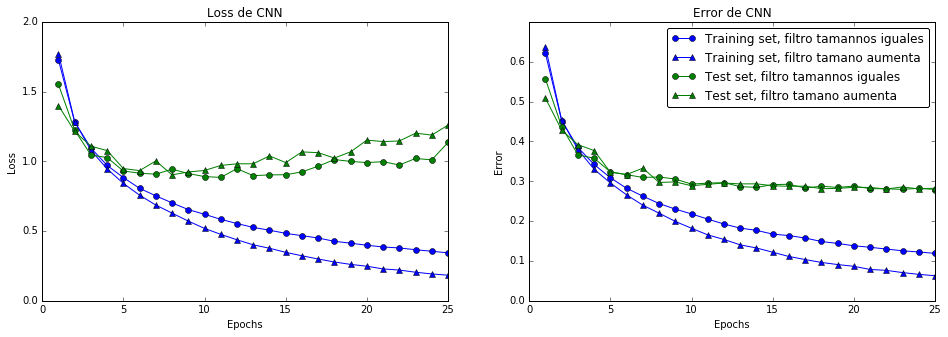

In [12]:
history_dict1 = hist4.history
history_dict2 = hist6.history

f, axarr = plt.subplots(1, 2,figsize=(16,5))

loss_values1 = history_dict1['loss']
val_loss_values1 = history_dict1['val_loss']
loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']
epochs1 = range(1, len(loss_values1) + 1)

axarr[0].plot(epochs1, loss_values1, 'bo-')
axarr[0].plot(epochs1, loss_values2, 'b^-')
axarr[0].plot(epochs1, val_loss_values1, 'go-')
axarr[0].plot(epochs1, val_loss_values2, 'g^-')
axarr[0].set_title('Loss de CNN')
axarr[0].set_ylim(0,2)
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

acc1 = history_dict1['acc']
val_acc1 = history_dict1['val_acc']
acc2 = history_dict2['acc']
val_acc2 = history_dict2['val_acc']

axarr[1].plot(epochs1, np.subtract(1,acc1), 'bo-', label = "Training set, filtro tamannos iguales")
axarr[1].plot(epochs1, np.subtract(1,acc2), 'b^-', label = "Training set, filtro tamano aumenta")
axarr[1].plot(epochs1, np.subtract(1,val_acc1), 'go-', label = "Test set, filtro tamannos iguales")
axarr[1].plot(epochs1, np.subtract(1,val_acc2), 'g^-', label = "Test set, filtro tamano aumenta")
axarr[1].set_title('Error de CNN')
axarr[1].set_ylim(0,0.7)
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Error')
axarr[1].legend(loc="upper right", fancybox= True)
plt.show()

En estos gráficos se aprecia el error de entrenamiento y pruebas con filtros de igual tamaño (3x3) en ambas tandas de capas convolucionales comparado con los errores con un tamaño de filtro que aumenta, un filtro en la primera tanda de tamaño 3x3 y en la siguiente con 5x5. Pudiendo ver que el que mantiene los filtros de igual tamaño se comporta mejor a lo largo del entrenamiento, además de producir un menor *overfitting*, por lo que en base a esto y a la métrica de *accuracy* se concluye que el primer modelo definido sigue siendo el mejor para este problema.  

Ahora se comprueban filtros de tamaño 5x5 y luego de 3x3 : 

In [7]:
model = Sequential()
model.add(Conv2D( 64, (5, 5), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D( 64, (5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D( 128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D( 128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
__________

In [8]:
opt = rmsprop(lr=0.001, decay=1e-3)
model.compile( optimizer=opt, loss='categorical_crossentropy' ,metrics=['acc'])
hist7 = model.fit(x_train, y_train,batch_size=100,epochs=25,
                  validation_data=(x_test, y_test),shuffle=True,verbose=1)

Train on 45741 samples, validate on 10000 samples
Epoch 1/25
45741/45741 [==============================] - 213s - loss: 1.8364 - acc: 0.3415 - val_loss: 1.5442 - val_acc: 0.4377
Epoch 2/25
45741/45741 [==============================] - 217s - loss: 1.3930 - acc: 0.5049 - val_loss: 1.3340 - val_acc: 0.5193
Epoch 3/25
45741/45741 [==============================] - 215s - loss: 1.2131 - acc: 0.5729 - val_loss: 1.2390 - val_acc: 0.5656
Epoch 4/25
45741/45741 [==============================] - 217s - loss: 1.0885 - acc: 0.6158 - val_loss: 1.1035 - val_acc: 0.6114
Epoch 5/25
45741/45741 [==============================] - 218s - loss: 1.0001 - acc: 0.6497 - val_loss: 1.0900 - val_acc: 0.6212
Epoch 6/25
45741/45741 [==============================] - 218s - loss: 0.9186 - acc: 0.6786 - val_loss: 1.0825 - val_acc: 0.6312
Epoch 7/25
45741/45741 [==============================] - 213s - loss: 0.8579 - acc: 0.6990 - val_loss: 1.0297 - val_acc: 0.6515
Epoch 8/25
45741/45741 [=======================

In [9]:
score = model.evaluate(x_test, y_test)
print "\nTEST CROSS ENTROPY LOSS = ", score[0]
print "\nTEST ACCURACY = ", score[1]

10000/10000 [==============================] - 28s    

TEST CROSS ENTROPY LOSS =  1.21838813868

TEST ACCURACY =  0.6899


En base a estos resultados se puede ver que el disminuir el tamaño de los filtros puede ser la peor opción para este problema ya que tiene la peor métrica de *accuracy* (**68,99%**) comparado con los otros CCP.  
Al aumentar el tamaño de filtros el tiempo de ejecución aumenta ya que son más parámetros los que se deben entrenar, pasando de 160 segundos por epochs a 220 segundos, aumentando linealmente con el número de epochs.  

Finalmente para esta experimentación del tamaño de filtros y del número de filtros en las capas convolucionales se llega a que mantener el tamaño de los filtros y aumentar el número de estos es lo más recomendado para este problema con los supuestos/configuraciones utilizadas. El escenario ideal para una mayor precisión sería una menor cantidad de filtros y tamaño en las primeras convolucionales, y a su vez una mayor cantidad de filtros con mayor tamaño, según los gráficos presentados anteriormente.

## F) Capa Pooling por Convolucional con stride

In [26]:
model = Sequential()
model.add(Conv2D( 64, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D( 64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='valid'))

model.add(Dropout(0.25))

model.add(Conv2D( 128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D( 128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3) , strides=(2, 2), padding='valid'))

model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512, activation ='relu'))
model.add(Dropout(0.3))
#model.add(Activation('relu'))
model.add(Dense(10,activation='softmax'))
#model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 32)        18464     
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)       36992     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 15, 15, 128)       147584    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 64)          73792     
__________

Siguiendo con la arquitectura creada en el item anterior, se procede a cambiar las capas de pooling, por capas convolucionales con stride 2 para ver si esto reduce la dimensionalidad, pudiendo ver que ahora las capas de "pooling" poseen parámetros que necesitan ser entrenados.

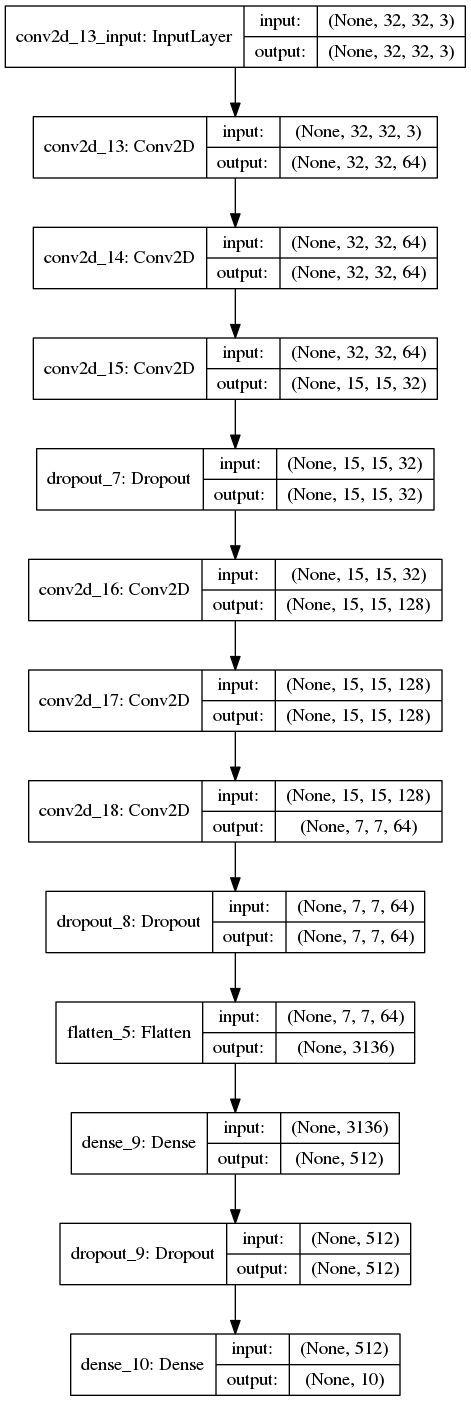

In [27]:
plot_model(model, to_file='aux.png', show_shapes=True)
Image(filename='aux.png')

En este gráfico se puede apreciar la dimensionalidad de la red a medida que se hace un forward pass por las distintas capas de la Red Convolucional. Se observan las 2 capas convolucionales con 64 filtros de tamaño 3x3 en una imagen de 32x32, a continuación pasa por la "nueva versión" pooling hecha por 32 filtros de stride 2, la reducción de dimensionalidad es notoria, de 32x32  la imagen pasó a 15x15 esto es por que los nuevos filtros se solapan en 2 filas a diferencia de 1 como sucede de manera implícita cuando se define un filtro. Esto hace redimensionar la imagen, luego pasa por una capa convolucional con más filtros, esto significa que en primer lugar la imagen es reducida con las características más importantes extraídas y luego filtrada por un número mayor de kernels, lo que llevaría a una búsqueda más exhaustiva de características relevantes. 

Nótese la diferencia con una capa de Max Pooling, ya que ésta última redimensionaba la imagen a dimensiones 16x16, no así como lo hace la capa convolucional con stride 2. Por lo tanto, el stride 2 reduce aún más la dimensionalidad que una capa pooling normal, ahora bien, se tendrá que observar empíricamente si estas capas mejoran el rendimiento de la red. A continuación se entrena esta red con la misma metodología que ha entregado buenos resultados anteriormente:

In [28]:
opt = rmsprop(lr=0.001, decay=1e-3)
model.compile( optimizer=opt, loss='categorical_crossentropy' ,metrics=['acc'])
hist6 = model.fit(x_train, y_train,batch_size=100,epochs=25,
validation_data=(x_test, y_test),shuffle=True,verbose=1)

Train on 45741 samples, validate on 10000 samples
Epoch 1/25
45741/45741 [==============================] - 147s - loss: 1.7299 - acc: 0.3777 - val_loss: 1.5470 - val_acc: 0.4609
Epoch 2/25
45741/45741 [==============================] - 147s - loss: 1.2980 - acc: 0.5412 - val_loss: 1.2970 - val_acc: 0.5412
Epoch 3/25
45741/45741 [==============================] - 147s - loss: 1.1163 - acc: 0.6069 - val_loss: 1.0746 - val_acc: 0.6205
Epoch 4/25
45741/45741 [==============================] - 147s - loss: 0.9903 - acc: 0.6515 - val_loss: 1.0366 - val_acc: 0.6446
Epoch 5/25
45741/45741 [==============================] - 147s - loss: 0.8922 - acc: 0.6873 - val_loss: 0.9734 - val_acc: 0.6628
Epoch 6/25
45741/45741 [==============================] - 147s - loss: 0.8159 - acc: 0.7135 - val_loss: 0.9811 - val_acc: 0.6666
Epoch 7/25
45741/45741 [==============================] - 147s - loss: 0.7506 - acc: 0.7368 - val_loss: 0.9647 - val_acc: 0.6703
Epoch 8/25
45741/45741 [=======================

In [30]:
score = model.evaluate(x_test, y_test)
print "\nTEST CROSS ENTROPY LOSS = ", score[0]

print "\nTEST ACCURACY = ", score[1]

 9984/10000 [============================>.] - ETA: 0s
TEST CROSS ENTROPY LOSS =  1.10037714024

TEST ACCURACY =  0.7075


El *accuracy* reportado (**70,75%**) no logra superar los modelos definidos anteriormente.

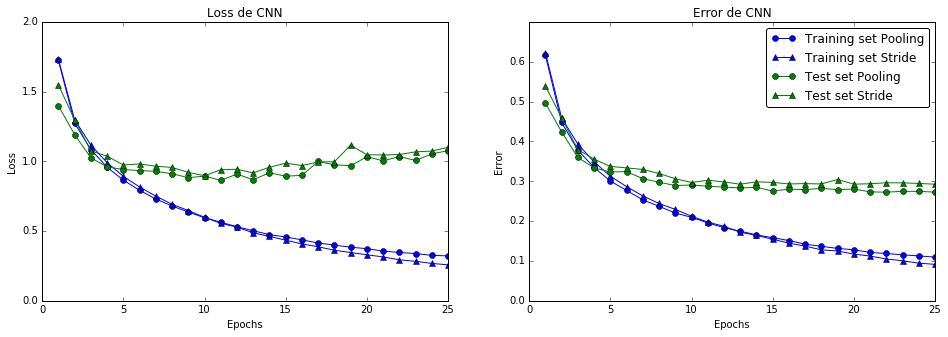

In [31]:
history_dict1 = hist4.history

history_dict2 = hist6.history

f, axarr = plt.subplots(1, 2,figsize=(16,5))

loss_values1 = history_dict1['loss']
val_loss_values1 = history_dict1['val_loss']
loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']
epochs1 = range(1, len(loss_values1) + 1)

axarr[0].plot(epochs1, loss_values1, 'bo-')
axarr[0].plot(epochs1, loss_values2, 'b^-')
axarr[0].plot(epochs1, val_loss_values1, 'go-')
axarr[0].plot(epochs1, val_loss_values2, 'g^-')
axarr[0].set_title('Loss de CNN')
axarr[0].set_ylim(0,2)
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

acc1 = history_dict1['acc']
val_acc1 = history_dict1['val_acc']
acc2 = history_dict2['acc']
val_acc2 = history_dict2['val_acc']

axarr[1].plot(epochs1, np.subtract(1,acc1), 'bo-', label = "Training set Pooling")
axarr[1].plot(epochs1, np.subtract(1,acc2), 'b^-', label = "Training set Stride")
axarr[1].plot(epochs1, np.subtract(1,val_acc1), 'go-', label = "Test set Pooling")
axarr[1].plot(epochs1, np.subtract(1,val_acc2), 'g^-', label = "Test set Stride")
axarr[1].set_title('Error de CNN')
axarr[1].set_ylim(0,0.7)
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Error')
axarr[1].legend(loc="upper right", fancybox= True)
plt.show()

Aquí se puede apreciar las diferencias de los errores para las arquitecturas de redes con capas convolucionales de stride 2 comparado con las capas Max Pooling de tamaño 2x2. Es posible observar que a medida que aumentan los epochs, el error de entrenamiento del modelo con stride es levemente menor que a la de max pooling, aunque al momento de predecir sobre el conjunto de pruebas, el error es menor en la pooling tradicional, comportamiento similar en el gráfico de función de pérdida. También se ve reflejado esto en la precisión total del modelo en las 25 epochs, para la red con stride, su precisión fue de 70,75%. En cambio la precisión de la red con pooling fue de 72,08%, una leve ventaja sobre la red de stride.   
Se puede observar que las diferencias en los errores y pérdidas son bastante leves comparadas con los otros gráficos en los que se comparan los modelos comparados, por lo que esto indica que utilizar una capa de stride reemplazando a la de pooling entrega resultados bastante similares.

## G) Regularizar

A continuación se regulariza un modelo con ejemplos de entrenamientos, que son transformadas con operaciones como rotación, traslación y reflexiones tanto verticales como horizontales.

In [32]:
from keras.preprocessing import image
datagen = image.ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)
hist7 = model.fit_generator(datagen.flow(x_train, y_train,batch_size=100),
        steps_per_epoch=x_train.shape[0]// 100,
        epochs=25,validation_data=(x_test, y_test),verbose=1)

Epoch 1/25
457/457 [==============================] - 147s - loss: 1.5716 - acc: 0.4473 - val_loss: 0.9932 - val_acc: 0.6539
Epoch 2/25
457/457 [==============================] - 147s - loss: 1.3702 - acc: 0.5124 - val_loss: 0.9813 - val_acc: 0.6616
Epoch 3/25
457/457 [==============================] - 147s - loss: 1.2995 - acc: 0.5389 - val_loss: 0.9293 - val_acc: 0.6749
Epoch 4/25
457/457 [==============================] - 147s - loss: 1.2453 - acc: 0.5554 - val_loss: 0.9318 - val_acc: 0.6722
Epoch 5/25
457/457 [==============================] - 147s - loss: 1.2173 - acc: 0.5660 - val_loss: 0.9287 - val_acc: 0.6774
Epoch 6/25
457/457 [==============================] - 147s - loss: 1.1901 - acc: 0.5756 - val_loss: 0.9300 - val_acc: 0.6777
Epoch 7/25
457/457 [==============================] - 147s - loss: 1.1671 - acc: 0.5898 - val_loss: 0.9094 - val_acc: 0.6826
Epoch 8/25
457/457 [==============================] - 147s - loss: 1.1469 - acc: 0.5911 - val_loss: 0.9028 - val_acc: 0.6831


Generar más ejemplos artificialmente en base a los ya existentes utilizando distintas transformaciones debería hacer más capaz a la red que entrege un mejor resultado al momento de predecir a cuál clase pertenece una imagen. Esto sucede dado que conoce desde otras perspectivas al objeto en estudio por lo que estará bien entrenada si un objeto está alrevés o más pequeño, con lo que al darle a la red un nuevo ejemplo de una clase en particular podrá chequear todas las transformaciones y entregar una mejor predicción mas general sobre los datos. En las siguientes celdas se ve experimentalmente que conviene más, entregarle a la red múltiples objetos de una misma clase o si basta con pocos ejemplos con varias transformaciones como las realizadas anteriormente.

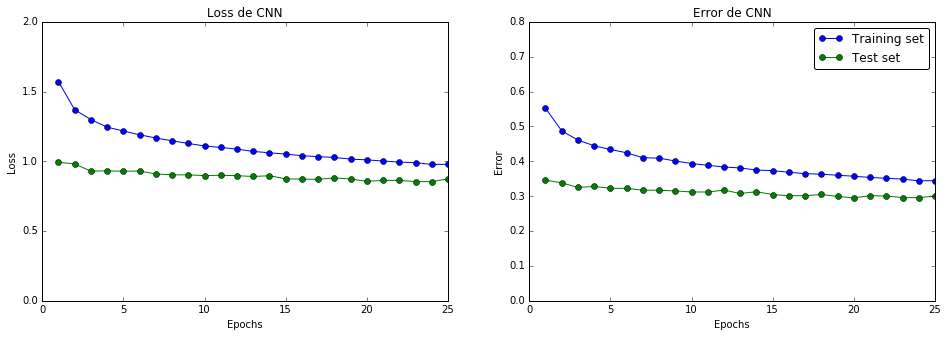

In [33]:
history_dict = hist7.history
plot_function(history_dict)

Se toma el modelo convolucional con stride anteriormente entrenado y se le entregan estos nuevos ejemplos transformados para seguir su entrenamiento, por lo que tendrá que de alguna forma aprender todo denuevo ya que un mismo objeto se puede presentar en la imagen de una manera totalmente nueva, no presente en todo el dataset, es por esto que en los gráficos se tiende a ver que la tendencia es un error de entrenamiento más alto que el de pruebas, ya que al modelo ya había sido entrenado para imágenes sin traslaciones/reflexiones, con lo que el error de pruebas obtendrá un valor más bajo que el de entrenamiento al observar estas nuevas imágenes generadas artificialmente.  
Se puede ver que el modelo luego de ya ser entrenado, sigue mejorando su desempeño disminuyendo el error si se aumentan las epochs re-entrenando con estas imágenes generadas, por lo que puede ser una buena elección al momento de encontrarse con un modelo quizas con no tan buen desempeño y mejorarlo (improvement).

In [34]:
score = model.evaluate(x_test, y_test)
print "\nTEST CROSS ENTROPY LOSS = ", score[0]

print "\nTEST ACCURACY = ", score[1]

 9984/10000 [============================>.] - ETA: 0s
TEST CROSS ENTROPY LOSS =  0.874016395092

TEST ACCURACY =  0.6996


Esta red neuronal luego de 25 epochs comparada con las demás, posee un error de pérdida *Cross entropy* 0.87, menor a los errores presentados en las otras arquitecturas. La precisión del modelo es alta con aproximadamente un 70%, no mejorando las redes definidas anteriormente pero sí mejorando su *accuracy* a lo largo del entrenamiento.

## H) Ejemplos confusos

En base al modelo entrenado anteriormente con las imágenes generadas se determinan los objetos que más tiende a confundir, o sea predecir erróneamente la clasificación de la imagen.

In [35]:
y_hat_class = model.predict_classes(x_test)
y_test_class = y_test.argmax(axis=1)

print "\nClases predecidas"
print y_hat_class
print "Clases reales"
print y_test_class

10000/10000 [==============================] - 6s     

Clases predecidas
[3 8 8 ..., 5 1 7]
Clases reales
[3 8 8 ..., 5 1 7]


In [36]:
y_hat_distintos= y_hat_class[np.not_equal(y_test_class,y_hat_class)]
y_test_distintos= y_test_class[np.not_equal(y_test_class,y_hat_class)]
aux = zip(y_hat_distintos,y_test_distintos)
print "Ejemplos mal clasificados ",len(aux)

frecuency = [ [i,aux.count(i)] for i in set(aux) ]
objetos_ordenados = np.asarray( sorted(frecuency,key=lambda x: x[1])[::-1] )
print "[(Predecido, Real), Frecuencia]"
print objetos_ordenados

Ejemplos mal clasificados  3004
[(Predecido, Real), Frecuencia]
[[(3, 5) 154]
 [(5, 3) 149]
 [(1, 9) 141]
 [(6, 4) 137]
 [(6, 3) 136]
 [(6, 2) 130]
 [(6, 5) 80]
 [(5, 7) 79]
 [(2, 3) 78]
 [(4, 2) 76]
 [(0, 2) 75]
 [(4, 7) 66]
 [(9, 1) 65]
 [(7, 4) 65]
 [(2, 4) 64]
 [(0, 8) 63]
 [(1, 8) 60]
 [(3, 2) 58]
 [(5, 2) 55]
 [(2, 0) 54]
 [(8, 0) 50]
 [(4, 3) 48]
 [(9, 0) 45]
 [(1, 0) 41]
 [(7, 5) 40]
 [(4, 5) 40]
 [(3, 4) 39]
 [(2, 5) 39]
 [(5, 4) 37]
 [(3, 6) 36]
 [(3, 7) 35]
 [(9, 3) 33]
 [(2, 6) 31]
 [(9, 8) 30]
 [(9, 7) 29]
 [(6, 7) 28]
 [(7, 2) 25]
 [(7, 3) 25]
 [(6, 0) 21]
 [(6, 9) 21]
 [(8, 1) 19]
 [(5, 6) 19]
 [(3, 8) 18]
 [(0, 3) 18]
 [(0, 9) 18]
 [(4, 6) 18]
 [(1, 3) 17]
 [(2, 7) 16]
 [(0, 4) 16]
 [(9, 5) 15]
 [(7, 9) 15]
 [(3, 9) 15]
 [(1, 4) 15]
 [(8, 9) 15]
 [(7, 0) 14]
 [(6, 1) 14]
 [(9, 2) 14]
 [(1, 5) 14]
 [(4, 0) 13]
 [(1, 7) 12]
 [(2, 8) 12]
 [(0, 7) 12]
 [(1, 2) 11]
 [(2, 9) 10]
 [(3, 0) 10]
 [(8, 3) 10]
 [(0, 5) 10]
 [(3, 1) 10]
 [(8, 4) 9]
 [(4, 8) 9]
 [(0, 1) 9]
 [(8, 5) 9

In [37]:
mayores = objetos_ordenados[:10]
print mayores
print label_names

[[(3, 5) 154]
 [(5, 3) 149]
 [(1, 9) 141]
 [(6, 4) 137]
 [(6, 3) 136]
 [(6, 2) 130]
 [(6, 5) 80]
 [(5, 7) 79]
 [(2, 3) 78]
 [(4, 2) 76]]
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [38]:
print "Los tipicos que se confunden son:"
for i in mayores:
    print "Se confunde un "+str(i[1])+" "+label_names[i[0][0]]+ " con "+label_names[i[0][1]]

Los tipicos que se confunden son:
Se confunde un 154 cat con dog
Se confunde un 149 dog con cat
Se confunde un 141 automobile con truck
Se confunde un 137 frog con deer
Se confunde un 136 frog con cat
Se confunde un 130 frog con bird
Se confunde un 80 frog con dog
Se confunde un 79 dog con horse
Se confunde un 78 bird con cat
Se confunde un 76 deer con bird


Las clases de imágenes que lideran en confusión de la predicción son las imagenes de gatos que la red predice como perro y el recíproco, o sea las imagenes de perro que la red predice como gato. Dentro de todas las clases del dominio del problema esta era la mas esperada, dado que los perros y gatos presentan muchas características en común y difieren en muy pocas, como en la forma de las orejas, su pelaje su forma física y tamaño. Por esto mismo la red tiende a confundir las imágenes de estas clases, esto también ocurre con los automóviles y camiones, yaque ambos poseen 4 ruedas, focos, espejos entre otros objetos, y solo difieren en la carrocería.  
Dato curioso es que con el modelo de stride tiende a predecir rana en varios casos (venados, gatos, pajaros, perros), siendo quizas la salida por "defecto" cuando a la red le cuesta predecir un objecto, ya que la forma de la rana es dificil de distinguir, teniendo una forma circular con extremidades bastante cortas como se ve en las imágenes a continuación.

A continuación se muestran varios ejemplos de imagenes del dataset que son generalmente confundidos:

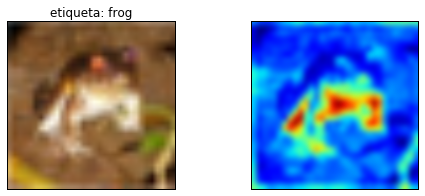

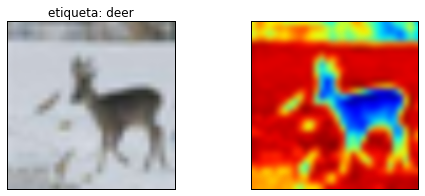

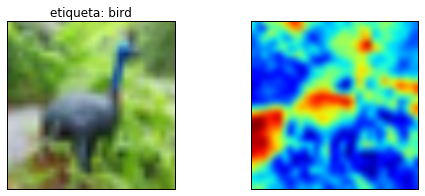

In [46]:
ver_imagen(X,Y,0)
ver_imagen(X,Y,20)
ver_imagen(X,Y,6)

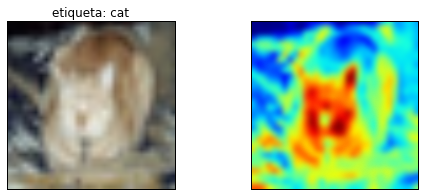

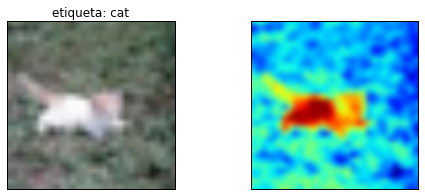

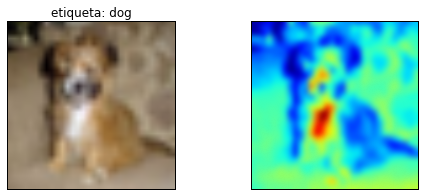

In [40]:
ver_imagen(X,Y,33)
ver_imagen(X,Y,39)
ver_imagen(X,Y,4600)

Perros y gatos representan varias características similares, como las 4 patas, cabeza, orejas, nariz, cola, pelaje, entre otros.

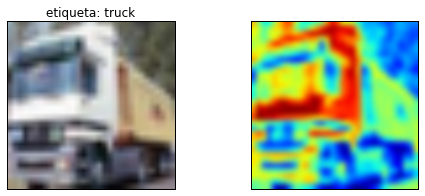

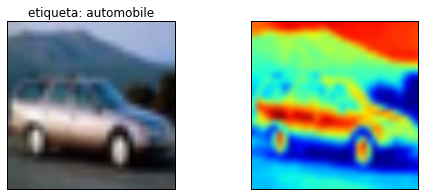

In [44]:
ver_imagen(X,Y,1)
ver_imagen(X,Y,4)

Los automóviles y los camiones son confundidos debido a su similitud obvia por el contexto de estos, ambos son vehículos de conducción 4 ruedas, solo que uno es mas grande que el otro y tiene una forma más rectangular.